<a href="https://colab.research.google.com/github/2303a52239/Explainable-AI-/blob/main/ensemble_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📊 Ensemble Model Performance:

               Model  Accuracy  Precision    Recall  F1-Score
0      Random Forest  0.704443   0.326659  0.237320  0.250944
1            Bagging  0.701947   0.287488  0.228641  0.236960
2      Voting (Soft)  0.709436   0.321614  0.227696  0.234938
3           Stacking  0.707439   0.285173  0.220131  0.216373
4  Gradient Boosting  0.700949   0.324781  0.211780  0.208947
5           AdaBoost  0.686470   0.208637  0.195553  0.193577


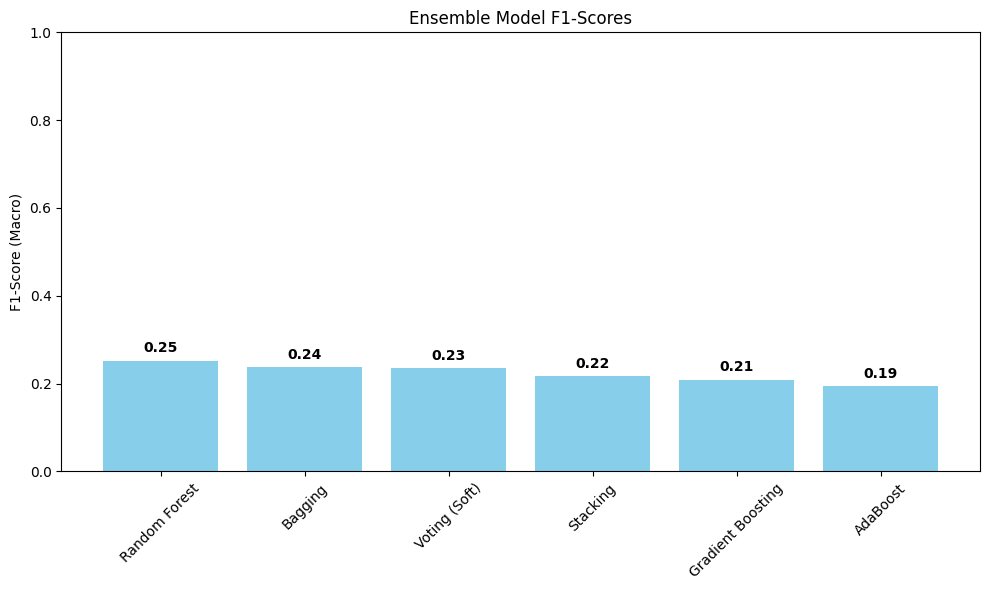

In [ ]:
# 🧠 Ensemble Models on HAM10000 metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 1️⃣ Load dataset
df = pd.read_csv("/content/HAM10000_metadata.csv")

# 2️⃣ Select features & target
features = ["age", "sex", "localization"]
target = "dx"
df = df[features + [target]].dropna(subset=[target])

# 3️⃣ Preprocessing
num_features = ["age"]
cat_features = ["sex", "localization"]

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

# 4️⃣ Encode target
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

X = df[features]
y = df[target]

# 5️⃣ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6️⃣ Define Ensemble Models (compatible with sklearn >=1.2)
models = {
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier()),  # ✅ fixed
    "Voting (Soft)": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier()),
            ('ada', AdaBoostClassifier()),
            ('gb', GradientBoostingClassifier())
        ],
        voting='soft'
    ),
    "Stacking": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier()),
            ('ada', AdaBoostClassifier()),
            ('gb', GradientBoostingClassifier())
        ],
        final_estimator=LogisticRegression(max_iter=500)
    )
}

# 7️⃣ Train & Evaluate
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average="macro", zero_division=0)
    })

# 8️⃣ Show Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
print("\n📊 Ensemble Model Performance:\n")
print(results_df)

# 9️⃣ Plot F1-Scores
plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["F1-Score"], color='skyblue')
plt.title("Ensemble Model F1-Scores")
plt.ylabel("F1-Score (Macro)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(results_df["F1-Score"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
